## Trabalho Proposto

Para o banco de dados Activity Recognition system based on Multisensor data fusion (AReM) Data Set do UCI repository, projete o sistema de reconhecimento de padrões, utilizando como algoritmos de classificação: redes MLP, redes RBF e SVM não-linear.

Compare os resultados obtidos pelos diferentes classificadores.

### Um pouco sobre o banco de dados

O dataset utilizado foi obtido utilizando medições feitas por três sensores acoplados em diferentes regiões do corpo enquanto a pessoa realizava movimentos específicos. O objetivo é desenvolver um sistema capaz de classificar o tipo de movimento feito a partir dos dados que foram gerados.

## Importando bibliotecas utilizadas

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import glob
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.svm import SVC
%matplotlib inline

## Inicialização e normalização dos dados

Um dataframe foi criado concatenando os dados de cada dataset disponibilizado e adicionando uma coluna de labels com valores de 1 a 7 identificando cada uma das classes.

Mapeamento das classes:

| Classe    | Label |
|-----------|-------|
| Bending 1 |   1   |
| Bending 2 |   2   |
| Cycling   |   3   |
| Lying     |   4   |
| Sitting   |   5   |
| Standing  |   6   |
| Walking   |   7   |

In [0]:
k = 0
df = pd.DataFrame()
folders = ['bending1','bending2','cycling','lying','sitting','standing','walking']
for i in folders:
    k = k+1
    a = glob.glob('./' + i + '/*.csv')
    a.sort()
    class_df = pd.DataFrame()
    for j in a:
        df_c = pd.read_csv(j, names=['time','avg_rss12', 'var_rss12', 'avg_rss13', 'var_rss13','avg_rss23', 'var_rss23'])
        class_df = class_df.append(df_c)
    class_df = class_df.drop([0,1,2,3,4])
    class_df = class_df.drop(['time'], axis=1)
    class_df = class_df.astype(float)
    class_df.insert(6,'label',k*np.ones(len(class_df.index)))    
    df = df.append(class_df)

df.head()

,avg_rss12,var_rss12,avg_rss13,var_rss13,avg_rss23,var_rss23,label
0,39.25,0.43,22.75,0.43,33.75,1.3,1.0
1,39.25,0.43,23.00,0.00,33.00,0.0,1.0
2,39.25,0.43,23.25,0.43,33.00,0.0,1.0
3,39.50,0.50,23.00,0.71,33.00,0.0,1.0
4,39.50,0.50,24.00,0.00,33.00,0.0,1.0


## Histograma de cada parâmetro

Primeiramente, o histograma de cada um dos parâmetros foi gerado para que seja possível observar seus comportamentos. Observa-se que os parâmetros "var_rss12" e "var_rss13" possuem um formato semelhante, porém ainda não é possível inferir se um deles pode ser descartado por conter um mesmo tipo de informação.

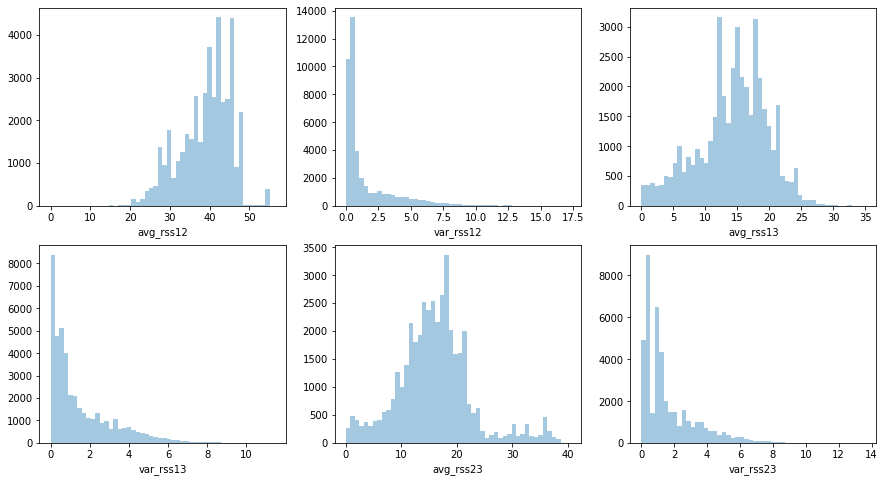

In [0]:
col = df.columns
fig = plt.figure(figsize=(15,8))
for i in range(1,7):    
    fig.add_subplot(2,3,i)
    sns.distplot(df[col[i-1]], kde=False) 

## Matriz de correlação

Uma segunda análise foi feita em relação aos valores de correlação dos parâmetros. Nota-se que os maiores valores obtidos estão em torno de $\pm 0,55$, o que significa que alguns parâmetros possuem uma correlação moderada. Apenas analisando isso não é possível concluir que dois parâmetros possuem uma mesma informação. Dessa maneira, nenhum deles é descartado e a dimensão do problema ainda não pode ser diminuída.

In [0]:
df.corr().style.format("{:.2}").background_gradient(cmap=plt.get_cmap('coolwarm'),axis=1)

,avg_rss12,var_rss12,avg_rss13,var_rss13,avg_rss23,var_rss23,label
avg_rss12,1.0,-0.39,-0.033,-0.29,-0.0041,-0.29,0.056
var_rss12,-0.39,1.0,0.15,0.55,0.046,0.54,0.29
avg_rss13,-0.033,0.15,1.0,0.05,0.44,0.18,-0.084
var_rss13,-0.29,0.55,0.05,1.0,0.079,0.53,0.15
avg_rss23,-0.0041,0.046,0.44,0.079,1.0,-0.055,-0.39
var_rss23,-0.29,0.54,0.18,0.53,-0.055,1.0,0.21
label,0.056,0.29,-0.084,0.15,-0.39,0.21,1.0


## Verificando a contribuição de cada parâmetro

Primeiramente os dados foram divididos utilizando a relação 70-30 entre os conjuntos de treino e teste, respectivamente. 

Utilizando uma rede MPL simples de 1 camada e 6 neurônios foram feitas 2 avaliações diferentes:

1.) Um parâmetro foi substituído pelo seu valor médio em cada iteração;

2.) Um parâmetro foi desconsiderado em cada iteração.

No primeiro ciclo todos os parâmetros foram utilizados e em seguida cada um deles foi sendo modificado, sendo explicitado no label do eixo X qual variável foi utilizada naquela iteração.

In [0]:
Y = np.array(df['label'])  
X = df.drop(['label'], axis=1)
xTrain, xTest, yTrain, yTest = train_test_split(X, Y, train_size = 0.7, random_state = 0)  #70% treino e 30% teste

In [0]:
clf = MLPClassifier(solver='adam', alpha=1e-5, hidden_layer_sizes=(6), random_state=1, max_iter=2000)
clf.fit(xTrain, yTrain)
efc = clf.score(xTest,yTest)

xTrain_m = xTrain.copy()
efc_mean = np.array([])

for col in xTrain_m.columns:
    xTrain_m[col] = xTrain_m[col].mean()
    clf = MLPClassifier(solver='adam', alpha=1e-5, hidden_layer_sizes=(6), random_state=1, max_iter=2000)
    clf.fit(xTrain_m, yTrain)
    efc_mean = np.append(efc_mean, clf.score(xTest,yTest))
    xTrain_m = xTrain.copy()
    
xTrain_d = xTrain.copy()
xTest_d  = xTest.copy()
efc_drop = np.array([])
    
for col in xTrain_m.columns:
    xTrain_d = xTrain_d.drop([col], axis=1)  
    xTest_d  = xTest_d.drop([col], axis=1)
    clf = MLPClassifier(solver='adam', alpha=1e-5, hidden_layer_sizes=(6), random_state=1, max_iter=2000)
    clf.fit(xTrain_d, yTrain)
    efc_drop = np.append(efc_drop, clf.score(xTest_d,yTest))
    xTrain_d = xTrain.copy()
    xTest_d  = xTest.copy()

Text(0.5, 1.0, 'Acurácia utilizando descarte de parâmetro')

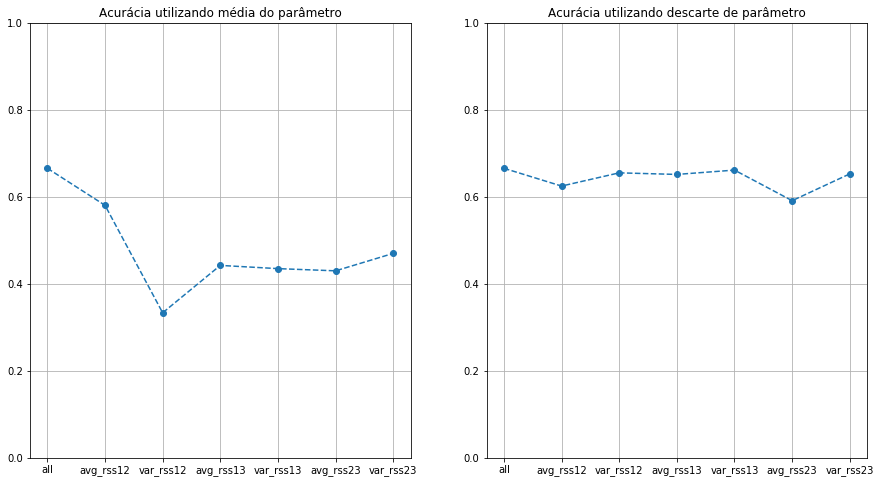

In [0]:
lb = ['all', 'avg_rss12', 'var_rss12', 'avg_rss13', 'var_rss13', 'avg_rss23', 'var_rss23']
fig = plt.figure(figsize=(15,8))
fig.add_subplot(1,2,1)
plt.plot(lb, np.append(efc, efc_mean), '--o')
plt.ylim([0,1])
plt.grid()
plt.title('Acurácia utilizando média do parâmetro')
fig.add_subplot(1,2,2)
plt.plot(lb, np.append(efc, efc_drop),'--o')
plt.ylim([0,1])
plt.grid()
plt.title('Acurácia utilizando descarte de parâmetro')

Não foi observada nenhuma melhora significativa ao descartar ou modificar algum dos parâmetros do dataframe em ambos os gráficos. Logo, foi decidido manter todos eles para a solução do problema de classificação proposto.

## Amplitude de cada classe

Para as análises seguintes, é necessário saber a quantidade de dados que cada uma das classes possui de modo a observar se alguma técnica para o balanceamento das mesmas deverá ser empregado. Logo, um gráfico contendo informações das amplitudes foi gerado.

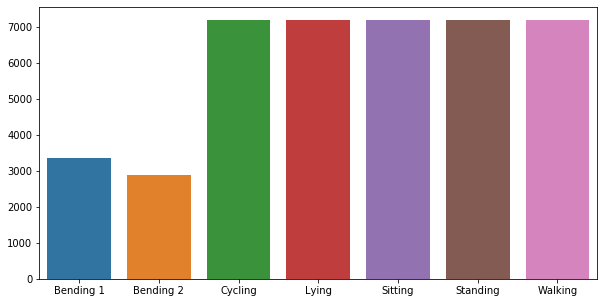

In [0]:
amp = np.array([])
for i in range(1,8):
    amp = np.append(amp, len(df.loc[(df['label'] == i)]))
    
classes = ['Bending 1','Bending 2','Cycling','Lying','Sitting','Standing','Walking']
plt.figure(figsize=(10,5))
sns.barplot(classes, amp)

Nota-se que as classes "bending 1" e "bending 2" possuem menos dados que as outras. Porém, a menor delas possui amplitude equivalente a cerca de 45% das de maior valor. Desse modo, há estatística suficiente para que ela seja corretamente prevista e não será necessário aplicar técnicas de balanceamento.

## Normalização dos dados

Antes de iniciar o treinamento das redes, cada uma das colunas do dataframe foi estandartizada de modo que todos os parâmetros tenham o valor de média igual a zero e desvio padrão igual a um.

In [0]:
Y = np.array(df['label'])  
X = df.drop(['label'], axis=1)
scaler = StandardScaler()
X = scaler.fit_transform(X)

## Separação em conjuntos de treino, validação e teste

Para que cada uma das redes utilizadas sejam corretamente treinadas e validadas, o dataframe foi dividido de forma que o conjunto de treino possua 70% dos dados e os conjuntos de validação e teste tenham 15% cada um.

In [0]:
xTrain, xAux, yTrain, yAux = train_test_split(X, Y, train_size = 0.7)        #70% treino
xEval, xTest, yEval, yTest = train_test_split(xAux, yAux, test_size = 0.5)   #15% validação e teste

## Redes MLP

Na escolha do perceptron multicamadas (MLP, do inglês Multi Layer Perceptron) foi definido o uso de três camadas ocultas. Para definir o número de neurônios a ser adotado em cada uma delas, o mesmo foi variado num intervalo de 1 a 151. Ao final, as curvas referentes aos resultados com os conjuntos de treino e validação foram obtidas e a partir delas foi definido a quantidade de neurônios a ser utilizado.

In [0]:
err_eval  = np.array([])
err_train = np.array([])
neurons = range(1,155,5)
for i in neurons:
    clf = MLPClassifier(hidden_layer_sizes=(i,i,i), max_iter=500)
    clf.fit(xTrain, yTrain)
    err_eval  = np.append(err_eval,  (1 - clf.score(xTest,yTest)))
    err_train = np.append(err_train, (1 - clf.score(xTrain,yTrain)))
    print(i)

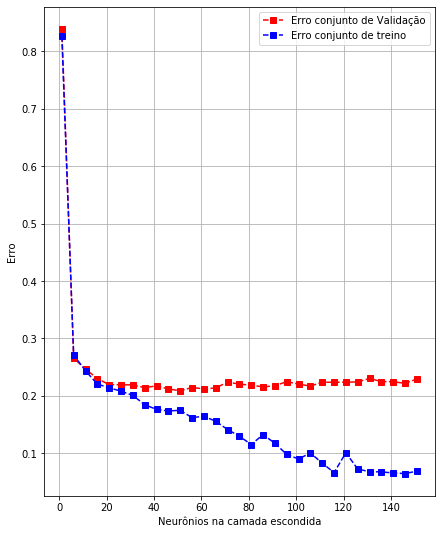

In [0]:
plt.figure(figsize=(7,9))
plt.plot(list(range(1,155,5)),err_eval,'--sr')
plt.plot(list(range(1,155,5)),err_train,'--sb')
plt.legend(['Erro conjunto de Validação','Erro conjunto de treino'])
plt.xlabel('Neurônios na camada escondida')
plt.ylabel('Erro')
plt.grid()

In [0]:
print("Erro de validação mínimo: ", np.min(err_eval))
print("Número de neurônios: ", neurons[np.argmin(err_eval)])

Erro de validação mínimo:  0.20849116161616166
Número de neurônios:  51


In [0]:
n_neurons = neurons[np.argmin(err_eval)]
clf = MLPClassifier(hidden_layer_sizes=(n_neurons,n_neurons,n_neurons), max_iter=500)
clf.fit(xTrain, yTrain)
print('Acurácia no conjunto de teste: ', round(100*clf.score(xTest,yTest),2), '%')

Acurácia no conjunto de teste:  79.25 %


## SVM Não-Linear

Para o SVM não linear, foi escolhido o kernel função de base radial (RBF, do inglês Radial Basis Function). Para esse dataset, adotou-se um classificador de margem suave utilizando o valor da constante C igual a 10. Os valores de gamma, responsável por definir até que ponto a influência de um único exemplo de treinamento alcança, foram variados de 0,01 a 1 e a partir do resultado foi definido o que resultou em maior acurácia.

In [0]:
C         = 10
gamma     = np.linspace(0.01,1,20)
err_eval  = np.array([])
err_train = np.array([])
for j in gamma:        
  clf = SVC(C = C, kernel = 'rbf', gamma = j)
  clf.fit(xTrain, yTrain)
  err_eval   = np.append(err_eval,  (1 - clf.score(xEval,yEval)))
  err_train  = np.append(err_train, (1 - clf.score(xTrain,yTrain)))
  print(j)

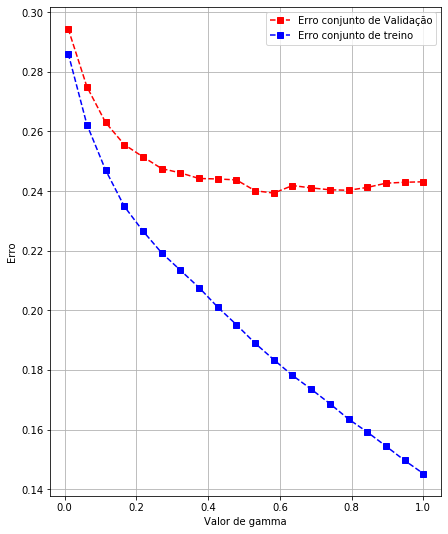

In [0]:
plt.figure(figsize=(7,9))
plt.plot(list(np.linspace(0.01,1,20)),err_eval,'--sr')
plt.plot(list(np.linspace(0.01,1,20)),err_train,'--sb')
plt.legend(['Erro conjunto de Validação','Erro conjunto de treino'])
plt.xlabel('Valor de gamma')
plt.ylabel('Erro')
plt.grid()

In [0]:
print("Erro de validação mínimo: ", np.min(err_eval))
print("Valor de gamma: ", gamma[np.argmin(err_eval)])

Erro de validação mínimo:  0.2392676767676768
Valor de gamma:  0.5831578947368421


In [0]:
n_gamma = gamma[np.argmin(err_eval)]
clf = SVC(C = C, kernel = 'rbf', gamma = n_gamma)
clf.fit(xTrain, yTrain)
print('Acurácia no conjunto de teste: ', round(100*clf.score(xTest,yTest),2), '%')

Acurácia no conjunto de teste:  77.0 %


## Redes RBF

A rede RBF implementada a seguir possui com função de ativação uma gaussiana e para se obter os melhores pesos para o vetor $w$ utilizou-se o algoritmo da pseudo-inversa. O treinamento da mesma foi feito variando o número de neurônios utilizados em um intervalo de 2 a 152. Ao analisar as curvas obtidas com os conjuntos de treino e validação, foi escolhido o número de neurônios que entrega um melhor resultado.

In [0]:
from sklearn.cluster import KMeans
from scipy.spatial import distance
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score

#Determinação da rede:
def RBFN(xTrain, yTrain, neurons):
    #Determinar centróide dos clusters:
    K_cent = neurons
    km     = KMeans(n_clusters= K_cent, max_iter= 200)
    km.fit(xTrain)
    cent   = km.cluster_centers_
    #Cálculo do sigma:
    dist_vector = distance.pdist(cent,'euclidean')
    dist_matrix = distance.squareform(dist_vector)
    sigma       = dist_matrix.max()/(np.sqrt(2*neurons))
    #Codificando a matriz de labels:
    encoder  = OneHotEncoder()
    yTrain   = encoder.fit_transform(yTrain.reshape(-1,1)).toarray()
    #Cálculo da gaussiana em cada dado de treinamento:
    shape  = xTrain.shape
    row    = shape[0]
    column = neurons
    phi    = np.zeros((row,column), dtype= float)
    for i in range(row):
        for j in range(column):
            #dist     = np.linalg.norm(xTrain.values[i]-cent[j])
            dist     = np.linalg.norm(xTrain[i]-cent[j])
            phi[i,j] = np.exp(-(dist**2)/(2*(sigma**2)))
    #Cálculo da pseudo-inversa:
    w = np.linalg.inv(phi.T @ phi) @ (phi.T @ yTrain)
    return w, cent, sigma


#Eficiência da rede utilizando os valores de w:
def RBFN_score(xTest, yTest, w, cent, sigma):
    row      = xTest.shape[0]
    column   = len(w)
    phiTest  = np.zeros((row,column), dtype= float)
    for i in range(row):
        for j in range(column):
            #distTest      = np.linalg.norm(xTest.values[i]-cent[j])
            distTest      = np.linalg.norm(xTest[i]-cent[j])
            phiTest[i,j]  = np.exp(-(distTest**2)/(2*(sigma**2)))
    predTest   = phiTest @ w
    prediction = np.zeros([predTest.shape[0],predTest.shape[1]])
    for i in range(len(predTest)):
        ind = np.where(predTest[i] == max(predTest[i]))
        prediction[i,ind] = 1
    encoder    = OneHotEncoder()
    yTest   = encoder.fit_transform(yTest.reshape(-1,1)).toarray()
    #prediction = encoder.inverse_transform(prediction)
    score = accuracy_score(prediction,yTest)
    return score

In [0]:
err_eval  = np.array([])
err_train = np.array([])
neurons = range(2,155,5)
for i in neurons:
    rbf, Kcent, sigma = RBFN(xTrain, yTrain, i)
    err_eval   = np.append(err_eval,  (1 - RBFN_score(xEval,yEval,rbf,Kcent,sigma)))
    err_train  = np.append(err_train, (1 - RBFN_score(xTrain,yTrain,rbf,Kcent,sigma)))
    print(i)

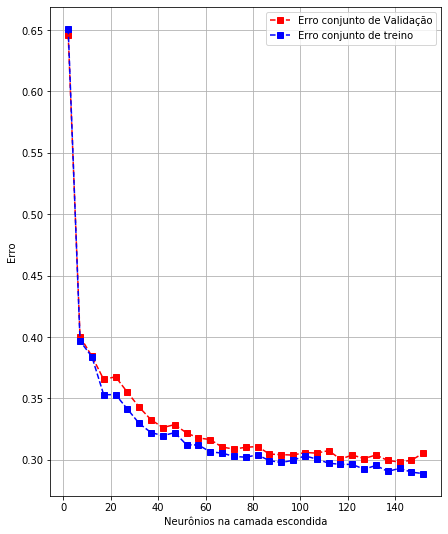

In [0]:
plt.figure(figsize=(7,9))
plt.plot(list(range(2,155,5)),err_eval,'--sr')
plt.plot(list(range(2,155,5)),err_train,'--sb')
plt.legend(['Erro conjunto de Validação','Erro conjunto de treino'])
plt.xlabel('Neurônios na camada escondida')
plt.ylabel('Erro')
plt.grid()

In [0]:
print("Erro de validação mínimo: ", np.min(err_eval))
print("Número de neurônios: ", neurons[np.argmin(err_eval)])

Erro de validação mínimo:  0.2981376262626263
Número de neurônios:  142


In [0]:
n_neurons = neurons[np.argmin(err_eval)]
rbf, Kcent, sigma = RBFN(xTrain, yTrain, n_neurons)
score = RBFN_score(xTest,yTest,rbf,Kcent,sigma)
print('Acurácia no conjunto de teste: ', round(100*score,2), '%')

Acurácia no conjunto de teste:  71.76 %


## Conclusão

Os três classificadores utilizados conseguiram boa acurácia com o conjunto de dados testado. O MLP e o SVM não linear alcançaram resultados semelhantes com 79,25% e 77,0%, respectivamente. Já a rede RBF obteve um resultado um pouco inferior aos outros dois, tendo acurácia de 71,76%. Caso uma taxa de erro seja admitida na aplicação, quaisquer classificadores aqui testados podem ser empregados sem grande perda de eficiência.